In [1]:
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf
import pandas as pd
import numpy as np

import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

###Import self-written library
import featexlib.debug as dbug
import featexlib.datagen as dgen

Data is ok
Out shape X,Y is: (100000, 32, 84) (100000,)
Number of classes: 10000
Max class label (should starts from 0): 9999
Show first 10 images:


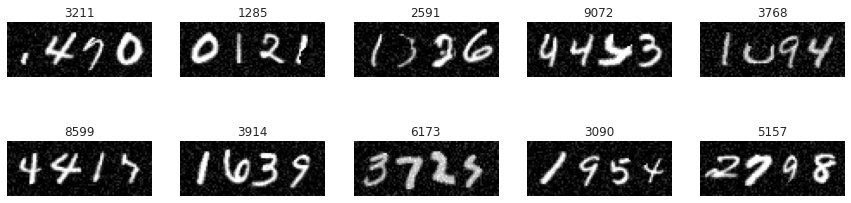

In [115]:
###Load data
###This cell should be used in another cell Can be used in another file

x_load, y_load = dgen.Image_generator.load_data()

###Get information about dataset
y_uniq = len(np.unique(y_load))
y_max = y_load.max()

###Check if data is consistent
print("Data is ok" if (y_max+1)==y_uniq else "Data is NOT consistent! Y values should be from 0 to MAX, without gaps!!!")

###Show some report. Label is uniq for each class but it doesnt related to "real" image values
print("===================================")
print("Out shape X,Y is:",x_load.shape, y_load.shape)
print("Number of classes:",y_uniq)
print("Max class label (should starts from 0):", y_max)
print("Show first 10 images:")
dbug.Debug.show_images_list(x_load[:10], y_load[:10], col_number = 5)

In [116]:
###Split data to test and train
n_train = 1000
n_test = 1000

def relabel_y(inp_y):
    inp_y_uniq = len(np.unique(inp_y))
    inp_y_max = inp_y.max()

    print("Number of classes:",inp_y_uniq)
    print("Max class label:", inp_y_max)
    print("Relabeling is not required" if (inp_y_max+1)==inp_y_uniq else "Y should be relabeled to 0-n")

    if not (inp_y_max+1)==inp_y_uniq:
        lookup_table = dict(zip(np.unique(inp_y), np.arange(len(np.unique(inp_y)))) )
        vect_lookup = np.vectorize(lookup_table.get)
        out_y = np.copy(inp_y)
        out_y = vect_lookup(out_y)
        print("Y was relabeled")
        print("New number of classes:", len(np.unique(out_y)))
        print("New max class label:", out_y.max())
        return out_y
    else:
        return inp_y

###Get X train and test
x_train, x_test = x_load[:n_train], x_load[n_train:n_train+n_test]

###Relabel Y array to make it from 0 to n. Relabel test and train together!!!
y_train_test = relabel_y(y_load[:n_train+n_test])
y_train, y_test = y_train_test[:n_train], y_train_test[n_train:n_train+n_test]
num_classes = len(np.unique(y_train_test))

print("===============Data is ready====================")
print("Shape X,Y for train:",x_train.shape,y_train.shape)
print("Shape X,Y for test: ",x_train.shape,y_train.shape)
print("Number of classes is:",num_classes)


Number of classes: 1827
Max class label: 9992
Y should be relabeled to 0-n
Y was relabeled
New number of classes: 1827
New max class label: 1826
===============Data is ready====================
Shape X,Y for train: (1000, 32, 84) (1000,)
Shape X,Y for test:  (1000, 32, 84) (1000,)
Number of classes is: 1827


In [117]:
###Reshape and then rescale dataset
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(x_train.shape[0],-1))
x_test  = scaler.transform(x_test.reshape(x_test.shape[0],-1))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1000, 2688) (1000,) (1000, 2688) (1000,)


In [132]:
###Prepare for training: check labels dimension (-1), change X to float32 instead of float64
ys = y_train.astype(int).reshape(-1)
xs = x_train.astype('float32')
ys_one_hot = tf.one_hot(ys, num_classes)

ys_test = y_test.astype(int).reshape(-1)
xs_test = x_test.astype('float32')

In [134]:
###Model parameters
pic_h = 32
pic_w = 84
num_feat = 128
#'num_classes' is defined before

###Minimizer taken from tf library. Actually, this code is redundant and can be simplified
def _minimize(strategy, tape, optimizer, loss, trainable_variables):
    """Minimizes loss for one step by updating `trainable_variables`.
    This is roughly equivalent to
    ```python
    gradients = tape.gradient(loss, trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, trainable_variables))
    ```
    However, this function also applies gradient clipping and loss scaling if the
    optimizer is a LossScaleOptimizer.
    Args:
    strategy: `tf.distribute.Strategy`.
    tape: A gradient tape. The loss must have been computed under this tape.
    optimizer: The optimizer used to minimize the loss.
    loss: The loss tensor.
    trainable_variables: The variables that will be updated in order to minimize
    the loss.
    """

    with tape:
        if isinstance(optimizer, lso.LossScaleOptimizer):
            loss = optimizer.get_scaled_loss(loss)

    gradients = tape.gradient(loss, trainable_variables)

    # Whether to aggregate gradients outside of optimizer. This requires support
    # of the optimizer and doesn't work with ParameterServerStrategy and
    # CentralStroageStrategy.
    aggregate_grads_outside_optimizer = (
        optimizer._HAS_AGGREGATE_GRAD and  # pylint: disable=protected-access
        not isinstance(strategy.extended,
                       parameter_server_strategy.ParameterServerStrategyExtended))

    if aggregate_grads_outside_optimizer:
        # We aggregate gradients before unscaling them, in case a subclass of
        # LossScaleOptimizer all-reduces in fp16. All-reducing in fp16 can only be
        # done on scaled gradients, not unscaled gradients, for numeric stability.
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
                                                       trainable_variables))
    if isinstance(optimizer, lso.LossScaleOptimizer):
        gradients = optimizer.get_unscaled_gradients(gradients)
    gradients = optimizer._clip_gradients(gradients)  # pylint: disable=protected-access
    if trainable_variables:
        if aggregate_grads_outside_optimizer:
            optimizer.apply_gradients(
                zip(gradients, trainable_variables),
                experimental_aggregate_gradients=False)
        else:
            optimizer.apply_gradients(zip(gradients, trainable_variables))

###Model build in low level way
class Model(tf.keras.Model):
    def __init__(self, cl_coeff, dropout_rate = 0.1, variance_epsilon=1e-3, stddev = 0.1, bias = 0.1):
        super(Model, self).__init__()
        
        ###Model is Lenet++ taken from 'A Discriminative Feature Learning Approachfor Deep Face Recognition'
        ###Num features is 'num_feat'
        ###Num classes is 'num_classes'
        
        #Input pixel numbers is pic_h*pic_w*1
        input_shape = (-1,pic_h,pic_w,1)
        
        ###Weights initialisation for convolution layers should be sqrt(2/k*k*c) as in Kaiming He's, 'Delving Deep into Rectifiers...')
        ###because using PReLU as activation function for Conv layers
        conv_init = tf.keras.initializers.he_normal()
        #conv_init = tf.random_normal_initializer(mean=0.0, stddev=stddev, seed=None)
        
        ###Biases initialisation for convolution layers. Should be zeroes.
        conv_bias_init = 'zeros'
        #conv_bias_init = tf.constant_initializer(bias)

        ###Model layers
        #1,2: (5/32)/1,2 x 2 PReLU
        #3: MaxPool 2/2,0
        #4,5: (5/64)/1,2 x 2 PReLU
        #6: MaxPool 2/2,0
        #7,8: (5/128)/1,2 x 2 PReLU
        #9: MaxPool 2/2,0 + Dropout
        #10: FC*num_feat - feature vector
        #11: FC*num_classes - output
        
        self.conv1_1 = tf.keras.layers.Conv2D(32, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, input_shape=input_shape[1:])
        self.conv1_1_pr = self.get_conv_act(alpha=0.5)
        self.conv1_2 = tf.keras.layers.Conv2D(32, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv1_2_pr = self.get_conv_act(alpha=0.5)
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        self.conv2_1 = tf.keras.layers.Conv2D(64, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv2_1_pr = self.get_conv_act(alpha=0.3)
        self.conv2_2 = tf.keras.layers.Conv2D(64, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv2_2_pr = self.get_conv_act(alpha=0.3)
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        
        ###For last two convolution layers added L1L2 regularizer
        self.conv3_1 = tf.keras.layers.Conv2D(128, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.conv3_1_pr = self.get_conv_act(alpha=0.2)
        self.conv3_2 = tf.keras.layers.Conv2D(128, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.conv3_2_pr = self.get_conv_act(alpha=0.2)
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        
        self.pool3_drop = tf.keras.layers.Dropout(dropout_rate)
        
        self.feat = tf.keras.layers.Dense(num_feat, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.out = tf.keras.layers.Dense(num_classes)
        
        ###Batch normalisation is not used
        #self.bn_conv1_2 = tf.keras.layers.BatchNormalization()
        #self.bn_conv2_2 = tf.keras.layers.BatchNormalization()
        #self.bn_conv3_2 = tf.keras.layers.BatchNormalization()
        #self.bn_feat = tf.keras.layers.BatchNormalization()
        #self.bn_out = tf.keras.layers.BatchNormalization()
        
        #Make centers tf.constants - because we update them manually
        self.centers = tf.constant(tf.zeros([num_classes,num_feat], dtype=tf.float32), name="centers")
        self.cl_coeff = cl_coeff
        self.dropout_rate = dropout_rate
        self.variance_epsilon = variance_epsilon
    
    def get_conv_act(self, alpha = 0.2):
        #return tf.keras.layers.LeakyReLU(alpha=alpha)
        return tf.keras.layers.PReLU(alpha_initializer = tf.constant_initializer(alpha))
    
    def get_regularizer(self,l1=0.01,l2=0.01):
        return tf.keras.regularizers.L1L2(l1=l1, l2=l2)
    
    def __call__(self, x, training=False):
        x_reshaped = tf.reshape(x, [-1,pic_h,pic_w,1])
        h_conv1_1 = self.conv1_1(x_reshaped)
        h_conv1_1_pr = self.conv1_1_pr(h_conv1_1)
        h_conv1_2 = self.conv1_2(h_conv1_1_pr)
        h_conv1_2_pr = self.conv1_2_pr(h_conv1_2)
        h_pool1 = self.pool1(h_conv1_2_pr)
        #h_pool1_bn = self.bn_conv1_2(h_pool1, training = training)
        
        tf.print("W Conv1 var:",tf.nn.moments(h_conv1_2,axes=[0,1,2,3])[1])
        
        h_conv2_1 = self.conv2_1(h_pool1)
        h_conv2_1_pr = self.conv2_1_pr(h_conv2_1)
        h_conv2_2 = self.conv2_2(h_conv2_1_pr)
        h_conv2_2_pr = self.conv2_2_pr(h_conv2_2)
        h_pool2 = self.pool2(h_conv2_2_pr)
        #h_pool2_bn = self.bn_conv2_2(h_pool2, training = training)
        
        tf.print("W Conv2 var:",tf.nn.moments(h_conv2_2,axes=[0,1,2,3])[1])
        
        h_conv3_1 = self.conv3_1(h_pool2)
        h_conv3_1_pr = self.conv3_1_pr(h_conv3_1)
        h_conv3_2 = self.conv3_2(h_conv3_1_pr)
        h_conv3_2_pr = self.conv3_2_pr(h_conv3_2)
        h_pool3 = self.pool3(h_conv3_2_pr)

        tf.print("W Conv3 var:",tf.nn.moments(h_conv3_2,axes=[0,1,2,3])[1])
        
        h_pool3_flt = tf.reshape(h_pool3, [-1,h_pool3.shape[1]*h_pool3.shape[2]*h_pool3.shape[3]])  #tf.reshape(h_pool3, self.get_flat_shape(h_pool3))
        #h_pool3_bn = self.bn_conv3_2(h_pool3_flt, training = training)
        
        h_pool3_flt_drop = self.pool3_drop(h_pool3_flt,training = training)

        h_feat = self.feat(h_pool3_flt_drop)
        
        tf.print("W Fc1   var:",tf.nn.moments(h_feat,axes=[0,1])[1])
        
        #features = self.bn_out(features, training = training)
        y_out = self.out(h_feat)
        
        #In case of library losses use softmax output
        return y_out, h_feat   #tf.nn.softmax(y_out)
    
    def set_center_loss_coeff(self, cl_coeff):
        self.cl_coeff = cl_coeff
    
    def get_center_loss(self, features, labels):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(tf.stop_gradient(self.centers), labels)
        center_loss = tf.reduce_sum(input_tensor=(features - centers_batch) ** 2, axis=[1])
        return center_loss

    def centers_update(self, features, labels, alpha):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(self.centers, labels)
        diff = centers_batch - features

        unique_label, unique_idx, unique_count = tf.unique_with_counts(labels)
        appear_times = tf.gather(unique_count, unique_idx)
        appear_times = tf.reshape(appear_times, [-1, 1])

        diff = diff / tf.cast((1 + appear_times), tf.float32)
        diff = alpha * diff
        
        label_reshaped = tf.reshape(labels,[-1,1])
        
        self.centers = tf.tensor_scatter_nd_sub(self.centers, label_reshaped, diff)
        
    def get_losses(self, x, y, training=False):
        y_pred, h_features = self(x, training=training)
        return self._get_losses(y, y_pred, h_features)

    def _get_losses(self, y, y_pred, h_features):
        y_one_hot = tf.one_hot(y, num_classes)
        center_loss = self.get_center_loss(h_features, y)
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_one_hot), logits=y_pred)
        tf.print("Using loss with center loss coeff:", self.cl_coeff)
        loss = tf.reduce_mean(input_tensor=(softmax_loss + self.cl_coeff * center_loss)) #    
        return loss, softmax_loss, center_loss
    
    def get_accuracy(self, x, y):
        y_pred, _ = self(x, training=False)
        result = tf.argmax(input=y_pred,axis=1)
        ground_truth = tf.reshape(y, [-1])
        correct_prediction = tf.equal(result, ground_truth)
        accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))
        return accuracy
    
    def get_centers(self):
        return self.centers
    
    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)

        with backprop.GradientTape() as tape:
            y_pred, h_features = self(x, training=True)
            ###Calculate centerloss but don't include it in loss function
            loss, softmax_loss, center_loss = self._get_losses(y, y_pred, h_features) 
            #Default loss cant be used...
            #loss = self.compiled_loss(y, y_pred, sample_weight, regularization_losses=self.losses)
        
        ###Simple optimiser, not used.
        #trainable_variables = self.trainable_variables
        #gradients = tape.gradient(loss, trainable_variables)
        #self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
                  self.trainable_variables)
        
        ###Update center loss    
        self.centers_update(h_features, y, 0.5) 
        
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
        
        #trace output
        tf.print({m.name: m.result() for m in self.metrics})
        
        return {m.name: m.result() for m in self.metrics}
    
#Not used here, because can't implement center loss
class Softmax_and_center_loss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_true), logits=y_pred)
        loss = tf.reduce_mean(input_tensor=softmax_loss ) 
        return loss


In [135]:
###Train model with centerloss 0.1 dropout 0.15, batch size 256, 20 epochs (center loss needs more). Train/test accuracy = ...
model = Model(0.1, dropout_rate = 0.15, variance_epsilon=1e-3, stddev = 0.01, bias = 0.1)
model_loss = Softmax_and_center_loss()
opt = tf.keras.optimizers.Adam()#learning_rate=1e-4
bunch_len = 256
model.compile(opt, loss=model_loss, metrics=["accuracy"])

dataset = tf.data.Dataset.from_tensor_slices((xs, ys))
dataset_batches = dataset.batch(bunch_len)

n_epochs = 1
n_center_loss_progress = 1

def center_loss_progress(n_prog,n_iter, koeff):
    return koeff*(n_prog+1)/(n_iter) if n_prog<n_iter else koeff

for i in range(n_epochs):
    tf.print("Step #"+str(i))
    #loss, softmax_loss, center_loss = model.get_losses(xs, ys)
    #tf.print('Accuracy: ', model.get_accuracy(xs, ys))
    #tf.print('=== Full loss   :', loss)
    #tf.print('=== Softmax loss: ', softmax_loss)
    #tf.print('=== Center loss : ', tf.reduce_mean(center_loss))
    #tf.print('Centers: ', model.get_centers())
    for batch in dataset_batches:    
        model.set_center_loss_coeff(center_loss_progress(i,n_center_loss_progress,0.0))
        model.train_step(batch)
        
print("====================================================")
print("Final train Accuracy:", model.get_accuracy(xs, ys))        
print("Final test Accuracy:", model.get_accuracy(xs_test, ys_test))     

Step #0
W Conv1 var: 1.7962122
W Conv2 var: 3.07581902
W Conv3 var: 5.30530119
W Fc1   var: 11.4626684
Using loss with center loss coeff: 0.0
{'accuracy': 0}
W Conv1 var: 1.66217256
W Conv2 var: 2.84252429
W Conv3 var: 4.13298321
W Fc1   var: 9.56939602
Using loss with center loss coeff: 0.0
{'accuracy': 0}
W Conv1 var: 1.5412569
W Conv2 var: 2.20812559
W Conv3 var: 2.00991058
W Fc1   var: 3.36878371
Using loss with center loss coeff: 0.0
{'accuracy': 0}
W Conv1 var: 1.46425128
W Conv2 var: 1.61669409
W Conv3 var: 0.671059668
W Fc1   var: 0.516671121
Using loss with center loss coeff: 0.0
{'accuracy': 0}
W Conv1 var: 1.39882994
W Conv2 var: 1.34058738
W Conv3 var: 0.437259
W Fc1   var: 1.25600612
Final train Accuracy: tf.Tensor(0.001, shape=(), dtype=float32)
W Conv1 var: 1.40301812
W Conv2 var: 1.34510839
W Conv3 var: 0.438004136
W Fc1   var: 1.2599324
Final test Accuracy: tf.Tensor(0.0, shape=(), dtype=float32)


In [26]:
#Get predictions and features for test dataframe
y_pred_logits, features_tf = model(xs_test)
features = np.array(features_tf)
y_pred_label = np.array(tf.argmax(y_pred_logits, axis=1))

W Conv1 var: 6.95887566
W Conv2 var: 10.0143147
W Conv3 var: 7.74391413
W Fc1   var: 82.9072189


In [27]:
###Show centers coords
np.array(model.centers)

array([[ -1.9242867 ,  -1.2769696 ],
       [  4.4159355 , -13.351339  ],
       [ -8.732005  ,   7.309432  ],
       [-15.808876  ,  -7.420747  ],
       [ -0.93458784,  12.040671  ],
       [-16.497854  ,   1.0617944 ],
       [  7.046907  ,  10.372195  ],
       [ -4.2405353 , -11.8541565 ],
       [  9.1233015 ,  -4.6500025 ],
       [  9.741671  ,   2.439099  ]], dtype=float32)

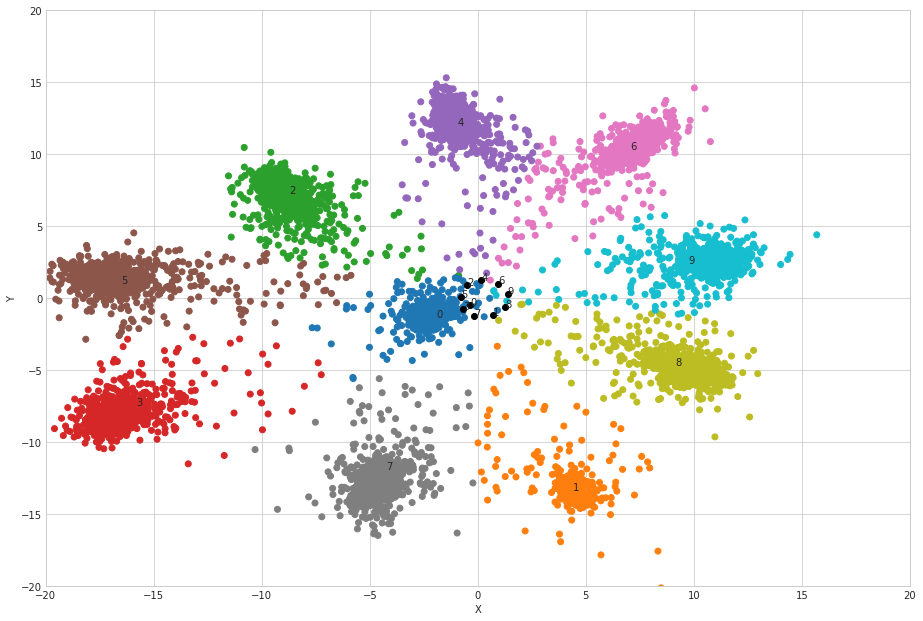

In [28]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)



class Plot_Report(object):
    def __init__(self, centers, class_vectors):
        self.fig = plt.figure()
        self.ax = self.fig.add_axes([-2,-2,2,2])
        self.centers = centers
        self.class_vectors = class_vectors
        self.center_names = ["0","1","2","3","4","5","6","7","8","9"]
        self.cmap = colors.ListedColormap(['#1f77b4', '#ff7f0e', 
                              '#2ca02c', '#d62728', 
                              '#9467bd', '#8c564b', 
                              '#e377c2', '#7f7f7f', 
                              '#bcbd22', '#17becf'])
        #self.cmap = discrete_cmap(10, 'cubehelix')
        
    def plot_data(self,x,y,c):
        self.ax.scatter(x,y, c=c , cmap=self.cmap, vmin=0, vmax=9) #, c=1 cmap=cmap
        
    def plot_centers(self):
        self.ax.scatter(self.centers[:,0],self.centers[:,1], c=[i for i in range(10)] , cmap=self.cmap, vmin=0, vmax=9) #, c=1 cmap=cmap
        for i, txt in enumerate(self.center_names):
            self.ax.annotate(txt, (self.centers[i,0], self.centers[i,1]))
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
    def plot_class_vectors(self):
        self.ax.scatter(self.class_vectors[0],self.class_vectors[1], c="black")
        for i, txt in enumerate(self.center_names):
            self.ax.annotate(txt, (self.class_vectors[0,i], self.class_vectors[1,i]))
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        
    def show(self):
        plt.xlim(-20, 20)
        plt.ylim(-20, 20)
        plt.show()
        
myplot = Plot_Report(np.array(model.centers), model.out.weights[0].numpy())

myplot.plot_data(features[:,0],features[:,1],y_pred_label)
myplot.plot_centers()
myplot.plot_class_vectors()
myplot.show()

In [29]:
np.array(model.centers)

array([[ -1.9242867 ,  -1.2769696 ],
       [  4.4159355 , -13.351339  ],
       [ -8.732005  ,   7.309432  ],
       [-15.808876  ,  -7.420747  ],
       [ -0.93458784,  12.040671  ],
       [-16.497854  ,   1.0617944 ],
       [  7.046907  ,  10.372195  ],
       [ -4.2405353 , -11.8541565 ],
       [  9.1233015 ,  -4.6500025 ],
       [  9.741671  ,   2.439099  ]], dtype=float32)

In [53]:
#Classification vectors
cv_x = model.out.weights[0].numpy()[0]
cv_y = model.out.weights[0].numpy()[0]

In [58]:
model.out.weights[0]

<tf.Variable 'dense_3/kernel:0' shape=(2, 10) dtype=float32, numpy=
array([[ 0.88432413,  0.68028337, -0.6672186 ,  1.2843869 , -0.15179698,
         1.276881  ,  0.08845953, -1.0143772 ,  0.2778069 , -0.8433039 ],
       [-1.3016163 ,  1.279158  , -1.2335091 , -0.55072093,  1.2718129 ,
         0.6290787 , -1.4957021 , -0.35204726,  0.9666587 ,  0.6032002 ]],
      dtype=float32)>